In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
import glob
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import tensorflow as tf
import keras
from keras.layers import Input, Dense, LeakyReLU
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

import os
import gzip
import sys

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

***
# LCC data import

In [ ]:
# Import lcc data files for wt protein and assign to variable (wt_windowsize)

wt_files=glob.glob('w*.lccdata')

window_range = list(range(2,51))
wt_dict = {}
for window, file in zip(window_range, wt_files):
    wt_dict[window] = pd.DataFrame(np.loadtxt(file)).drop(columns=0) 

In [ ]:
# Import lcc data files for mutant protein and assign to variable (mutant_windowsize)

m_files=glob.glob('m*.lccdata')

D132H_dict = {}
for window, file in zip(window_range, m_files):
    D132H_dict[window] = pd.DataFrame(np.loadtxt(file)).drop(columns=0)

***
# 1.1 RF model and feature importance

In [64]:
# Cross validation for hyperparameter tuning
def RF_classifier(window, wt, mutant):

    ''' 
    Build RF classifier, than perform cross validation to select best parameters
    '''
    
    # Add labels
    wt_label = np.zeros(len(wt))
    mutant_label = np.ones(len(mutant))
    
    # Concatenate data frames and label arrays
    X_train_full = pd.concat([wt, mutant])
    y_train_full = np.concatenate((wt_label, mutant_label))
    
    # Separate training and validation sets and print relevant shapes
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, stratify=y_train_full, test_size=0.2)
    
    print('Window size:', str(window))
    print(X_train.shape)
    print(X_valid.shape)
    print(y_train.shape)
    print(y_valid.shape)
    
    # Define parameter range
    
    parameters = {
    "n_estimators":[100,250,500],
    "max_depth":[16,32,64]
    }
    
    rfc = RandomForestClassifier()
    
    # Perform cross validation to determine best parameters
    cv = GridSearchCV(rfc,parameters,cv=5, verbose=1)
    
    cv.fit(X_train, y_train)
    
    def display(results):
        print(f'Best parameters are: {results.best_params_}')
        print("\n")
        mean_score = results.cv_results_['mean_test_score']
        std_score = results.cv_results_['std_test_score']
        params = results.cv_results_['params']
        for mean,std,params in zip(mean_score,std_score,params):
            print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
            
    display(cv)

In [ ]:
rf_wt_12 = RF_classifier(12, wt_dict[12], D132H_dict[12])

In [6]:
# Build and train random forest classifier with selected hyperparameters + extract feature importance
def RFC(window, wt, mutant):

    # Add labels
    wt_label = np.zeros(len(wt))
    mutant_label = np.ones(len(mutant))
    
    # Concatenate data frames and label arrays
    X_train_full = pd.concat([wt, mutant])
    y_train_full = np.concatenate((wt_label, mutant_label))
    
    # Separate training and validation sets and print relevant shapes
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, stratify=y_train_full, test_size=0.2)
    
    # Build random forest classifier
    rnd_clf = RandomForestClassifier(n_estimators = 400, max_leaf_nodes = 32, n_jobs=-1)
    
    # Fit rf model
    rnd_clf.fit(X_train, y_train)
    
    # Perform predictions on validation set
    y_pred_rf = rnd_clf.predict(X_valid)
    
    # Evaluate model accuracy
    accuracy = accuracy_score(y_valid, y_pred_rf)
    
    confusion = confusion_matrix(y_valid, y_pred_rf)
    
    # Extract importance of each position
    position = []
    importance = []
    
    for name, score in zip(X_train.columns, rnd_clf.feature_importances_):
        position.append(name)
        importance.append(score)
    
    upper_limit = 70 + 1 - window # max protein length + 1
    
    x = np.arange(1 + window / 2 ,upper_limit + window / 2) + 90
    
    rf_pos_importance = pd.DataFrame({'Position': x, 'Importance:': importance})
    
    rf_pos_importance.to_csv('pos_imp'+str(window)+'.csv')
    
    return accuracy, confusion, rf_pos_importance

-------------------- Tester results --------------------
Window size = 12
Accuracy =  0.873 

Confusion matrix:


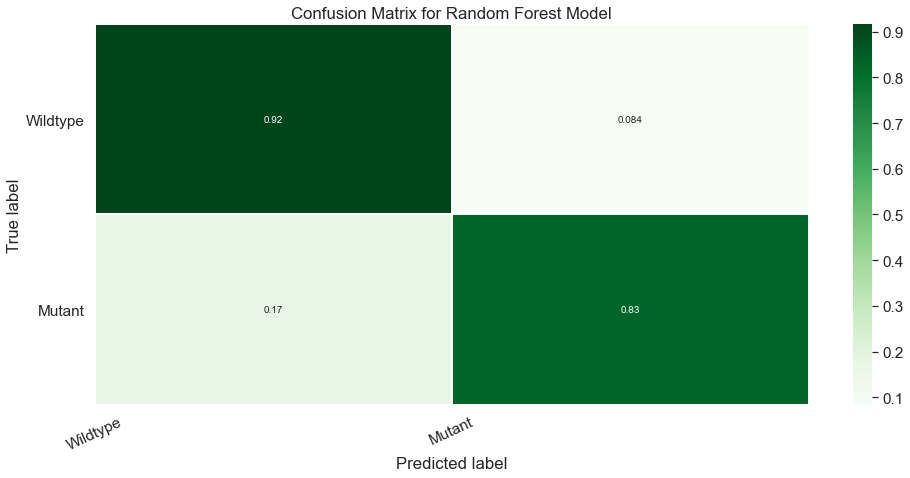



Results dataframe:


,Position,Importance:
0,97.0,0.002256
1,98.0,0.003547
2,99.0,0.002813
3,100.0,0.003764
4,101.0,0.016926


In [7]:
# Testing random forest classifier for window = 12
acc_12_test, conf_12_test, rf_wt_12_test = RFC(12, wt_dict[12], D132H_dict[12])

print('-------------------- Tester results --------------------')
print('Window size = 12')
print('Accuracy = ', acc_12_test, '\n')
print('Confusion matrix:')

conf_12_test = conf_12_test.astype('float') / conf_12_test.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(conf_12_test, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)
class_names = ['Wildtype', 'Mutant']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

print('\n')
print('Results dataframe:')
display(rf_wt_12_test.head())

In [19]:
# Initializing dictionaries
acc_dict = {}
rf_dict = {}
conf_mat = {}
n_sim = 10

# Running random forest analysis for all ws
for window in tqdm(window_range):
        
    acc_dict[window], conf_mat[window], rf_dict[window] = RFC(window, wt_dict[window], D132H_dict[window])

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [23:02<00:00, 28.22s/it]


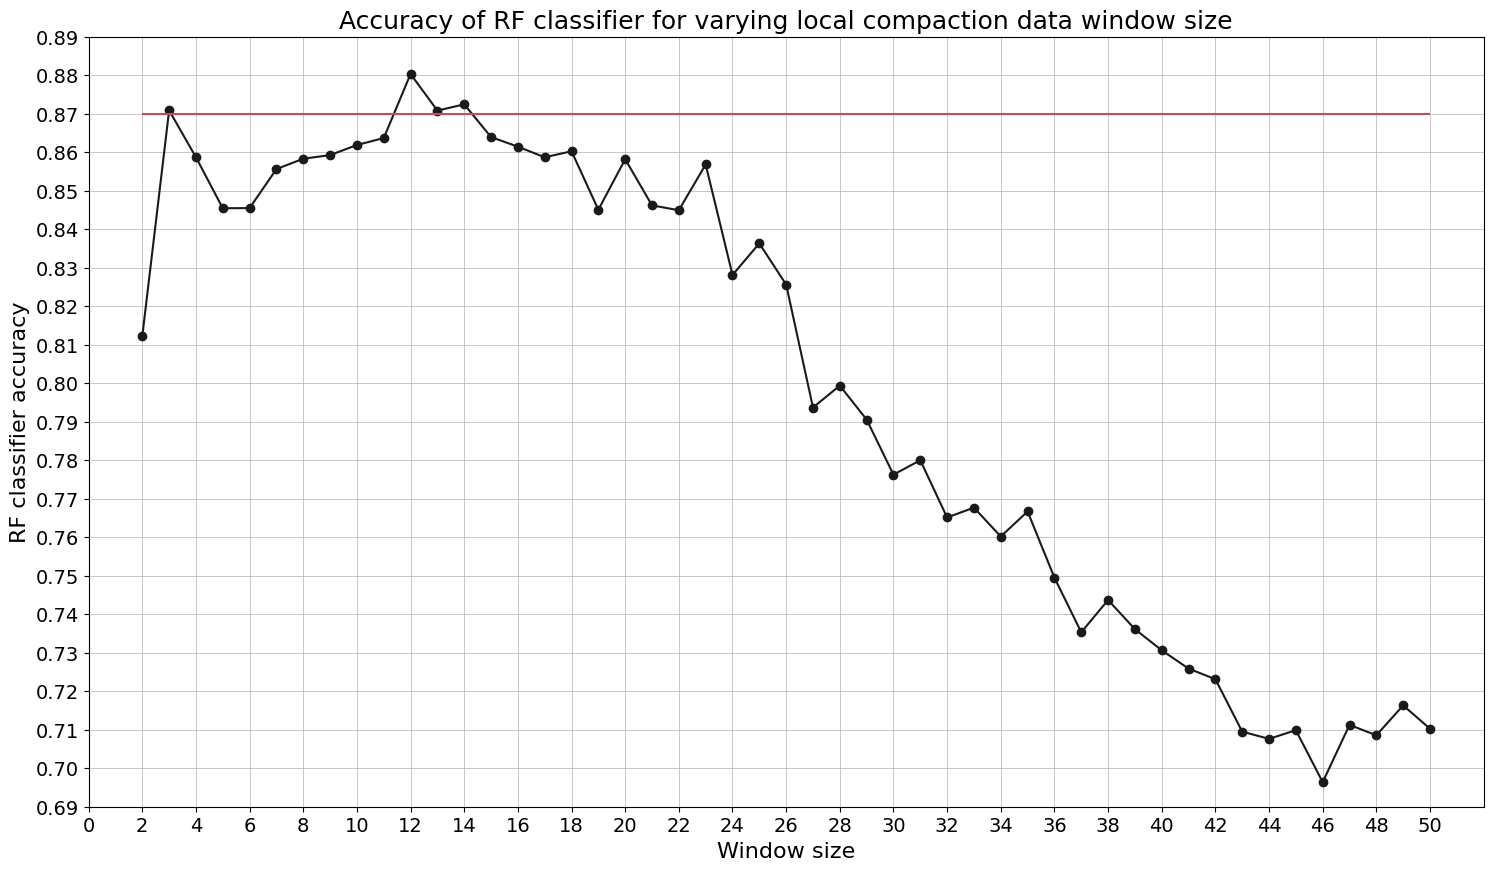

In [23]:
# Plot random forest classification accuracy at varying ws
ws = range(2,51)
plt.figure(figsize=(18,10))
plt.plot(list(acc_dict.keys()), list(acc_dict.values()), 'k-o')
plt.xlim()
plt.grid(which='both', linewidth=0.5)
plt.title('Accuracy of RF classifier for varying local compaction data window size', fontsize=18)
plt.xlabel('Window size', fontsize=16)
plt.ylabel('RF classifier accuracy', fontsize=16)
plt.xlim(1,52)
plt.ylim(0.69,0.89)
plt.xticks(np.arange(0,51,2), fontsize=14)
plt.yticks(np.arange(0.69,0.89, 0.01), fontsize=14)
plt.hlines(0.87,2,50,colors='r', label = 'Threshold')
plt.savefig('Accuracy at diff ws_7.png', dpi =300)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 44.78it/s]


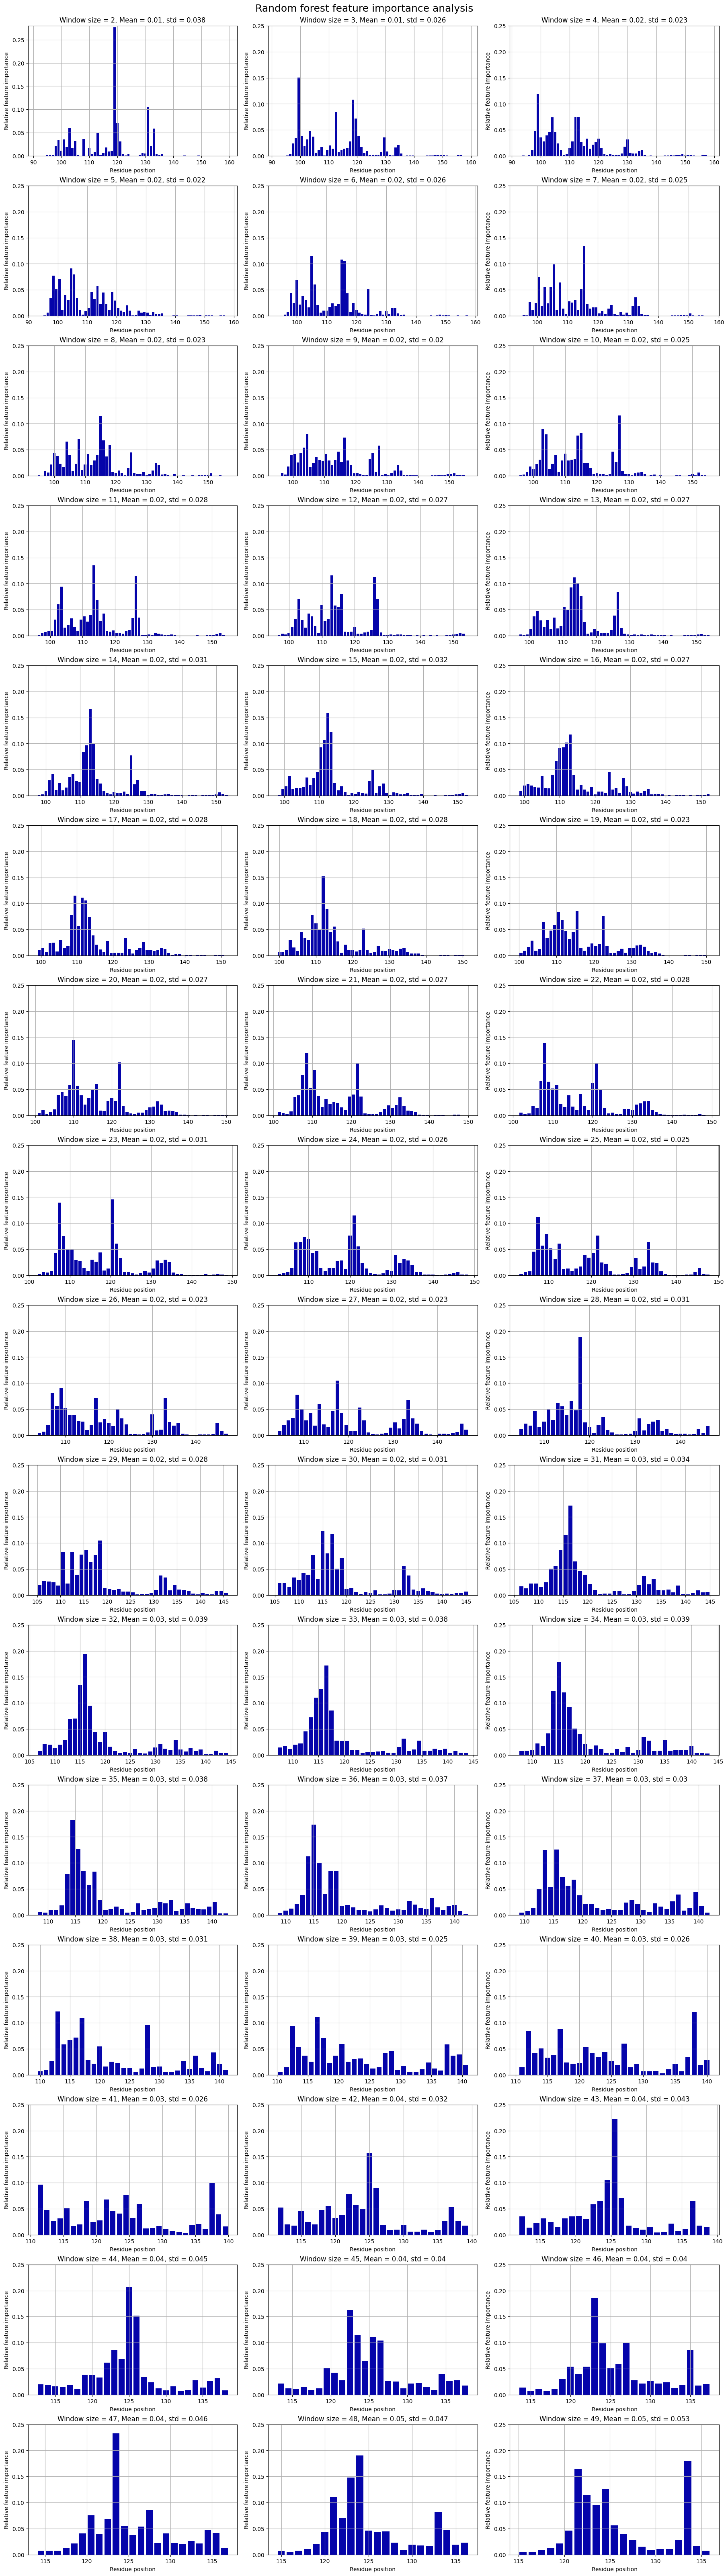

In [26]:
# Plot feature importance for each window size
fig, ax = plt.subplots(16,3, figsize=(18,4*16), constrained_layout=True)

for i in tqdm(range(48)):
    yyrf = (rf_dict[i+2]['Importance:'].values)
    meanrf = np.mean(yyrf)
    stdrf = np.std(yyrf)
    ax[i//3][i%3].bar(rf_dict[i+2]['Position'], yyrf, color='#0504aa')
    ax[i//3][i%3].set_title('Window size = {}, Mean = {}, std = {}'.format(i+2, np.round(meanrf,2), np.round(stdrf,3)))
    ax[i//3][i%3].grid()
    ax[i//3][i%3].set_xlabel('Residue position')
    ax[i//3][i%3].set_ylabel('Relative feature importance')
    ax[0][0].set_ylim(0,0.28)
    ax[i//3][i%3].set_ylim(0,0.25)
    
#plt.supylabel("Feature importance")
plt.suptitle("Random forest feature importance analysis", fontsize=18)
#plt.supxlabel("Position")

plt.show()

Text(0, 0.5, 'Compression ratio')

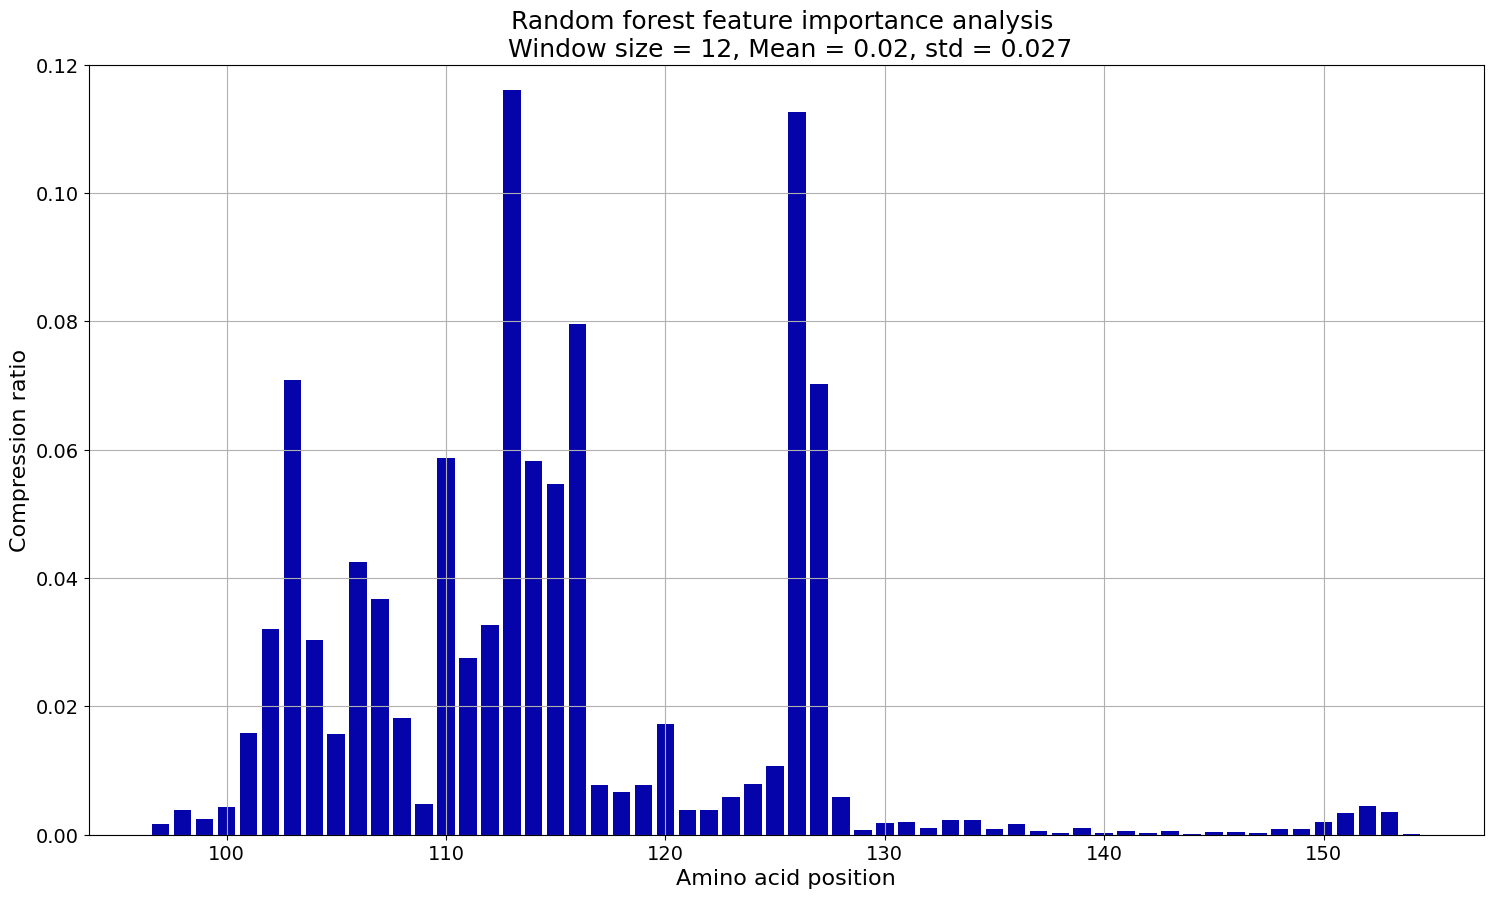

In [25]:
# Feature importance plot for ws 12
plt.figure(figsize=(18,10))
yrf = rf_dict[12]['Importance:'].values
mean2 = np.mean(yrf)
std2 = np.std(yrf)
plt.bar(rf_dict[12]['Position'], yrf, color='#0504aa')
plt.title('Random forest feature importance analysis \n Window size = {}, Mean = {}, std = {}'.format(12, np.round(mean2,2), np.round(std2,3)), fontsize = 18)
plt.ylim(0,0.12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.xlabel('Amino acid position', fontsize = 16)
plt.ylabel('Compression ratio', fontsize = 16)

In [219]:
## Concatenate high performing wt and mutant lc plots

# Concatenate wt and mutant dataframes

wt_unf = pd.concat([wt_3, wt_4, wt_7, wt_8, wt_9, 
                    wt_10, wt_11, wt_12, wt_13, wt_14, wt_15, 
                    wt_16, wt_17, wt_18, wt_20, wt_23], axis = 1)
    
D132H_unf = pd.concat([D132H_3, D132H_4, D132H_7, 
                       D132H_8, D132H_9, D132H_10, D132H_11, D132H_12, 
                       D132H_13, D132H_14, D132H_15, D132H_16, D132H_17, 
                       D132H_18, D132H_20, 
                       D132H_23], axis = 1)

colnames = [*range(0,920)]
colnames
wt_unf.columns = colnames
D132H_unf.columns = colnames


In [225]:
# Train random forest with concatenated data and determine accuracy

acc_com,confusion, report, rf_wt_com = RFC(wt_unf, D132H_unf)

(64000, 920)
(16000, 920)
(64000,)
(16000,)
Accuracy: 0.935875


In [12]:
## function for data filtering at different levels

def filter_lcdata(window, rf_data, wt, D132H, level):
    
    ''' Filters local compaction data according to feature importance'''
    
    # Calculate max importance
    max_rf_imp = rf_data['Importance:'].max()
    
    # Determine threshold according to filtering level
    threshold = ((max_rf_imp/100)*level)
    
    # Determine positions to keep
    rf_filtered = rf_data[rf_data['Importance:'] > threshold]
    
    idx_keep = rf_filtered.index.values.tolist()
    
    index_keep = [int(i) for i in idx_keep]
    
    # Drop "irrelevant" positions
    filtered_wt = wt[index_keep]

    filtered_D132H = D132H[index_keep]
    
    # Filtered data to csv
    filtered_wt.to_csv(path_or_buf="wt_filtered_lcc_" + str(window) + "_" + str(level) + ".lccdata", sep='\t', mode='w')
    
    filtered_D132H.to_csv(path_or_buf="D132H_filtered_lcc_" + str(window)  + "_" + str(level) + ".lccdata", sep='\t', mode='w')
    
    return filtered_wt, filtered_D132H, index_keep

In [13]:
filt_3_wt, filt_3_m, idx3 = filter_lcdata(3, rf_dict[3], wt_dict[3], D132H_dict[3], 50)
filt_12_wt, filt_12_m, idx12 = filter_lcdata(12, rf_dict[12], wt_dict[12], D132H_dict[12], 50)
filt_20_wt, filt_20_m, idx20 = filter_lcdata(20, rf_dict[20], wt_dict[20], D132H_dict[20], 50)

Number of trajectory frames read in:  40000


<Figure size 432x288 with 0 Axes>

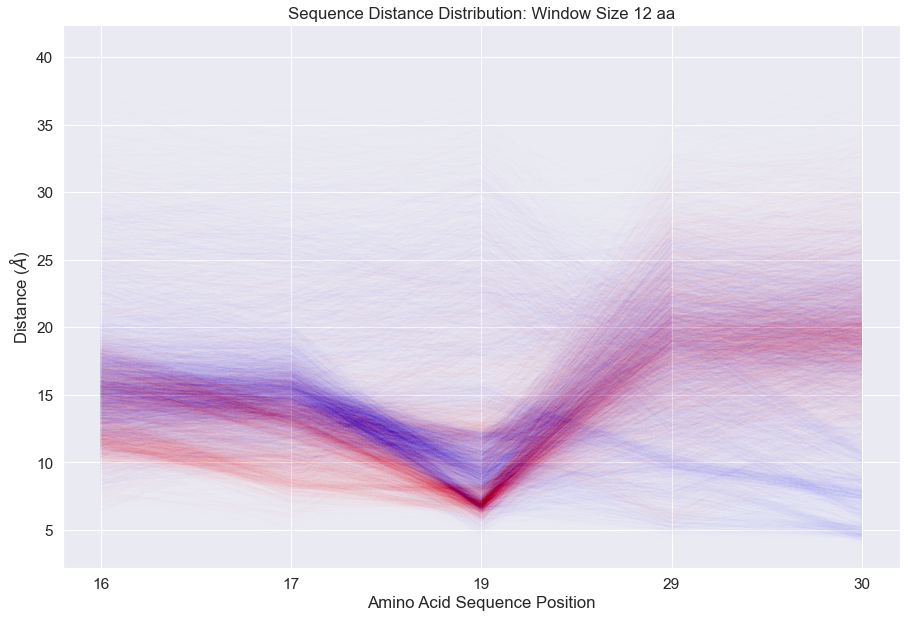

In [18]:
# Plots filtered LC data for ws 12

filtered_train_test_12_wt_np  = filt_12_wt.to_numpy()
filtered_train_test_D132H_12_np  = filt_12_m.to_numpy()
window = 12
frame_number = filtered_train_test_12_wt_np.shape[0] #get the number of frames read
print ("Number of trajectory frames read in: ", frame_number)
x = [str(i) for i in idx12]
plt.clf()
plt.figure(figsize=(15,10))
plt.xlabel('Amino Acid Sequence Position')  
plt.ylabel('Distance ($\AA$)')  #Angstrom
#plt.xticks(x)
plot_name = 'Sequence Distance Distribution: Window Size ' + str(window) + ' aa'
plt.title(plot_name) 
for z in range (1,frame_number,10):
    y=filtered_train_test_12_wt_np[z] #read row for distances along primary sequence    
    plt.plot(x,y, color = 'blue', alpha=0.002) #avoid reading header in y
    k=filtered_train_test_D132H_12_np[z]
    plt.plot(x,k, color = 'red', alpha=0.002)
    

figure_name = "filtered_data_local_compaction_plot_" + str(window) + ".png"
plt.savefig(figure_name, dpi = 300)